In [8]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# ——— CONFIG ———
IMAGE_PATH = "/kaggle/input/dataset1112/pexels-photo-1108099.jpeg"
OUTPUT_FOLDER = "./output"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ——— MODEL LOAD ———
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_caption(img, prompt, max_len):
    inputs = processor(img, text=prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_length=max_len,
        num_beams=5,
        return_dict_in_generate=True,
        output_scores=True
    )
    text = processor.decode(out.sequences[0], skip_special_tokens=True).strip()
    # approximate confidence
    scores = torch.stack(out.scores, dim=1).max(-1).values
    conf   = float(scores.mean().exp().item())
    return text, conf

def overlay_captions(img, short_cap, long_cap):
    draw = ImageDraw.Draw(img)
    W, H = img.size

    # choose a font ~4% of image height
    try:
        font = ImageFont.truetype("arial.ttf", size=int(H * 0.04))
    except IOError:
        font = ImageFont.load_default()

    margin = 10
    # short caption in blue at top
    draw.text((margin, margin), short_cap, fill="blue", font=font)

    # measure detailed-caption height via textbbox
    bbox = draw.textbbox((0, 0), long_cap, font=font)
    th = bbox[3] - bbox[1]

    # detailed caption in red at bottom
    draw.text((margin, H - th - margin), long_cap, fill="red", font=font)
    return img

# ——— RUN ———
img = Image.open(IMAGE_PATH).convert("RGB")

short_caption, short_conf = generate_caption(img, "a concise caption:", max_len=16)
detailed_caption, det_conf = generate_caption(img, "a detailed description:", max_len=64)

# overlay and save image
annotated = overlay_captions(img, short_caption, detailed_caption)
out_img_path = os.path.join(OUTPUT_FOLDER, "annotated_receipt.jpg")
annotated.save(out_img_path)

# write JSON
caps = {
    "short_caption": short_caption,
    "short_confidence": short_conf,
    "detailed_caption": detailed_caption,
    "detailed_confidence": det_conf
}
with open(os.path.join(OUTPUT_FOLDER, "captions.json"), "w") as jf:
    json.dump(caps, jf, indent=2)

print(f"Annotated image saved to {out_img_path}")
print(f"Captions JSON saved to {OUTPUT_FOLDER}/captions.json")


Annotated image saved to ./output/annotated_receipt.jpg
Captions JSON saved to ./output/captions.json


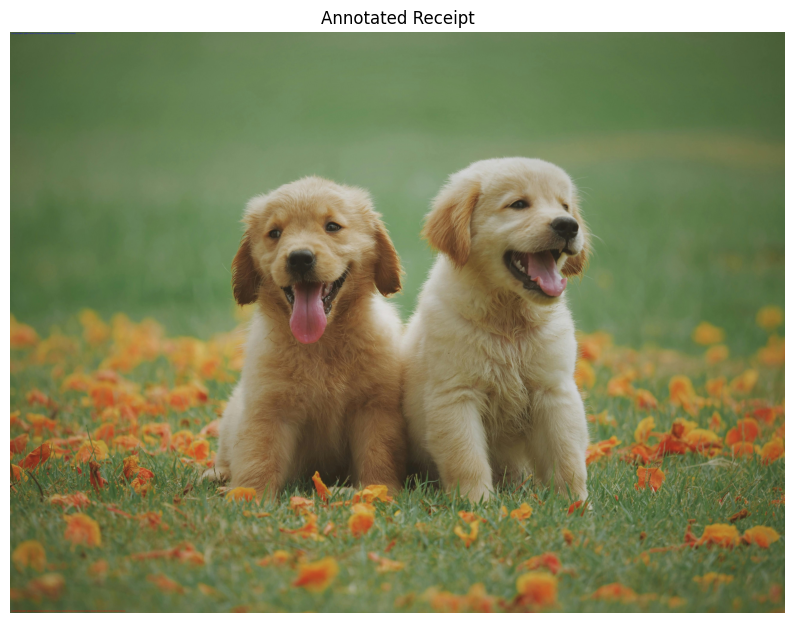

 Captions & Confidence Scores:

 Short Caption   : a concise caption : golden retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve (Confidence: 0.262)
 Detailed Caption: a detailed description : golden retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve retrieve (Confidence: 0.478)


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import json

# Display the annotated image
img = Image.open("./output/annotated_receipt.jpg")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Annotated Receipt")
plt.show()

# Load and print captions.json
with open("./output/captions.json", "r") as f:
    captions = json.load(f)

print(" Captions & Confidence Scores:\n")
print(f" Short Caption   : {captions['short_caption']} (Confidence: {captions['short_confidence']:.3f})")
print(f" Detailed Caption: {captions['detailed_caption']} (Confidence: {captions['detailed_confidence']:.3f})")
